In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import scipy.ndimage as ndimage
from sklearn import linear_model

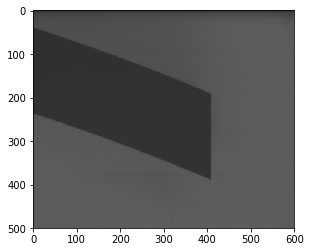

In [2]:
#input_img=cv.imread('342165_20161020-205235_L.tif')
input_img=cv.imread('342165_20161020-205235_R.tif')
pre_img= input_img[0:500, 0:600]

plt.figure(1)
plt.imshow(pre_img)

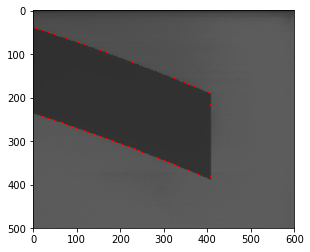

In [3]:
gray = cv.cvtColor(pre_img,cv.COLOR_BGR2GRAY)
ret, thresh = cv.threshold(gray,0,255,cv.THRESH_BINARY_INV+cv.THRESH_OTSU)
plt.imshow(gray)

# noise removal
kernel = np.ones((4,4),np.uint8)
opening = cv.morphologyEx(thresh,cv.MORPH_OPEN,kernel, iterations = 3)
# sure background area
sure_bg = cv.dilate(opening,kernel,iterations=5)
# Finding sure foreground area
dist_transform = cv.distanceTransform(opening,cv.DIST_L2,5)
ret, sure_fg = cv.threshold(dist_transform,0.7*dist_transform.max(),255,0)
# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv.subtract(sure_bg,sure_fg)

# Marker labelling
ret, markers = cv.connectedComponents(sure_fg)
# Add one to all labels so that sure background is not 0, but 1
markers = markers+1
# Now, mark the region of unknown with zero
markers[unknown==255] = 0

markers = cv.watershed(pre_img,markers)
pre_img[markers == -1] = [255,0,0]

plt.imshow(pre_img)

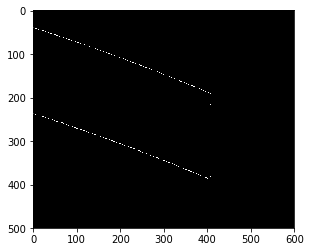

In [13]:
plt.imshow(markers == -1, cmap = 'gray')

In [29]:
markers = markers[1:-2, 1:-2]

x = list(range(markers.shape[1]))
y = list(range(markers.shape[0]))

X, Y = np.meshgrid(x, y)

x_border = X[markers == -1]
y_border = Y[markers == -1]

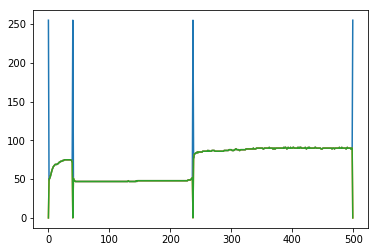

In [33]:
plt.plot(pre_img[:, 1])

In [25]:
markers

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=int32)